In [1]:
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

from scene import Scene, GaussianModel
from scene.dataset_readers import SceneInfo, CameraInfo
from scene.gaussian_model import BasicPointCloud

In [2]:
with open("debug/scene_info_root.pkl", "rb") as f:
    scene_info = pickle.load(f)

with open("debug/pcd.pkl", "rb") as f:
    pcd = pickle.load(f)

In [3]:
dir(scene_info)

['__add__',
 '__annotations__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_field_defaults',
 '_field_types',
 '_fields',
 '_fields_defaults',
 '_make',
 '_replace',
 'count',
 'index',
 'nerf_normalization',
 'ply_path',
 'point_cloud',
 'test_cameras',
 'train_cameras']

In [6]:
orientations = []
translations = []

for cam_info in scene_info.train_cameras:
    # scene_info saves R_WC and t_cw
    orientations.append(cam_info.R) # transpose of the rotation matrix
    translations.append( -cam_info.R @ cam_info.T)

orientations = np.array(orientations)
translations = np.array(translations)

This is how the trajectory in world coordinates looks like after getting projected to the x-z (horizontal) plane

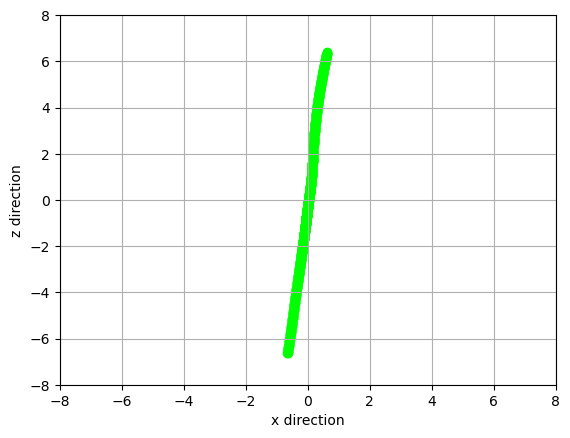

In [7]:
plt.scatter(translations[:, 0], translations[:, 2], color="lime") # projected to x-z plane
plt.xlabel("x direction")
plt.ylabel("z direction")
ax = plt.gca()
ax.set_xlim((-8,8))
ax.set_ylim((-8,8))
plt.grid()
plt.show()

This is how our pointcloud looks like when projected to the x-z plane

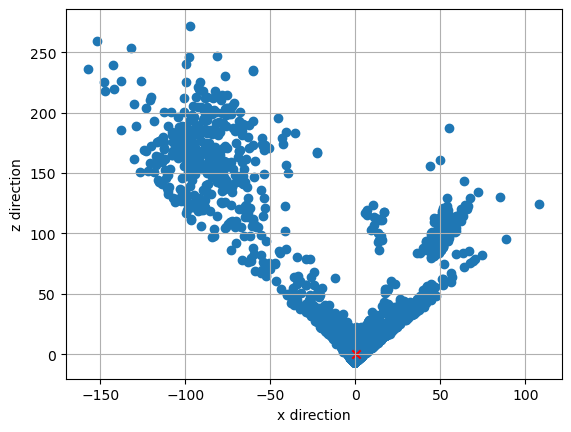

In [19]:
xyz = pcd.points
xz = xyz[:, [0, 2]] # keep only first and third column

center = np.median(xz, axis=0, keepdims=True)

plt.scatter(xz[:, 0], xz[:, 1]) # projected to x-z plane
plt.scatter(center[:, 0], center[:, 1], marker="x", color="red")

plt.xlabel("x direction")
plt.ylabel("z direction")
ax = plt.gca()
# ax.set_xlim((-16,16))
# ax.set_ylim((-16,16))
plt.grid()
plt.show()

This is how it looks like when we overlay the trajectory on the points

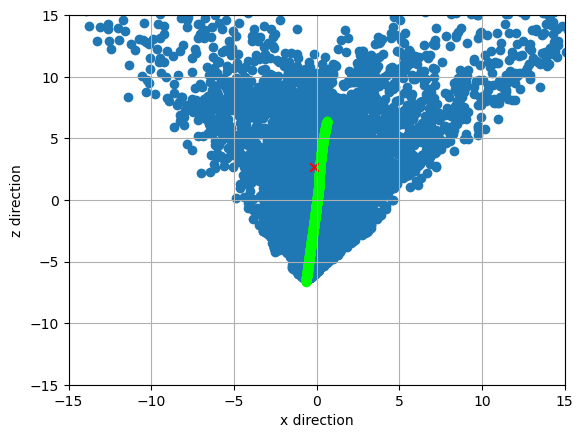

In [16]:
xyz = pcd.points
xz = xyz[:, [0, 2]] # keep only first and third column

plt.scatter(xz[:, 0], xz[:, 1]) # projected to x-z plane
plt.scatter(translations[:, 0], translations[:, 2], color="lime") # projected to x-z plane
plt.scatter(center[:,0], center[:,1], color="red", marker="x")

plt.xlabel("x direction")
plt.ylabel("z direction")
ax = plt.gca()
ax.set_xlim((-15,15))
ax.set_ylim((-15,15))
plt.grid()
plt.show()


In [17]:
# The average distance of 3d points to the center of the point cloud
dist = np.linalg.norm((xz - center), axis=1, ord=1)
dist = np.mean(dist, keepdims=True)
print("Mean distance of the points to the point cloud median in xz plane: ", dist.item())
print("Scene extent computed by Nerf++ norm: ", scene_info.nerf_normalization["radius"])

Mean distance of the points to the point cloud median in xz plane:  6.288559436798096
Scene extent computed by Nerf++ norm:  7.559489250183106


Dividing the scene into a grid

In [18]:
# Origin placement is an important issue, we don't know for sure where the world origin will be
# The origin of the grid system is placed on the left-most edge of the whole grid

X_extent = 40
Z_extent = 150

grid_size = (5, 1) # 5-by-4 grid of cells, each cell should be a scene
num_cells = grid_size[0] * grid_size[1]

# Sizes of the cells based on the number of cells and the extent of the scene
cell_W = X_extent / grid_size[1]
cell_H = Z_extent / grid_size[0]





In [69]:
from typing import NamedTuple

class Cell(NamedTuple):
    cell_id: int
    scene: Scene
    H: float
    W: float
    origin: np.ndarray
